In [17]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [6]:
# Uses "runners always bisect rope" hueristic from
#  https://physics.stackexchange.com/questions/666475/final-position-of-weight-hanging-from-two-opposed-pulleys-on-ropes/666519#666519

# In trying to find the final position of runners supporting a hanging weight, it was noted that
#  as long as the runners aren't slack and as long as their final position does not have them touching,
#  they will always bisect the angle in the rope they produce

# This script uses that concept to iteratively approximate the final orientations.

# After each step, the bisection angles are calculated and the runners all move half-way to the new angle.
# After many steps, the runners will approach the correct bisection angles.

# Special code was added to handle runners that get stuck against each other. If two runners are detected
#  to be crossing, their endpoints are set to the point in space where both are fully extended and touching.

# Slack runners isn't appropriately handled and instead slack runners oscillate and never converge.
#  Presumably some is_slack[] flag needs to be added and slack runners not processed.

# Brian Coventry 2021

In [46]:

# Utility functions

#https://stackoverflow.com/questions/55816902/finding-the-intersection-of-two-circles
def circle_intersections(x0, y0, r0, x1, y1, r1):
    # circle 1: (x0, y0), radius r0
    # circle 2: (x1, y1), radius r1

    d=np.sqrt((x1-x0)**2 + (y1-y0)**2)
    
    # non intersecting
    if d > r0 + r1 :
        return None
    # One circle within other
    if d < abs(r0-r1):
        return None
    # coincident circles
    if d == 0 and r0 == r1:
        return None
    else:
        a=(r0**2-r1**2+d**2)/(2*d)
        h=np.sqrt(r0**2-a**2)
        x2=x0+a*(x1-x0)/d   
        y2=y0+a*(y1-y0)/d   
        x3=x2+h*(y1-y0)/d     
        y3=y2-h*(x1-x0)/d 

        x4=x2-h*(y1-y0)/d
        y4=y2+h*(x1-x0)/d
        
        return (x3, y3, x4, y4)

    
# start1 + slope1 * t1 = start2 + slope2 * t2
# where t1 [0, 1] and t2 [0, 1]
#
# slope1 * t1 - slope2 * t2 = start2 - start1 0
# 
# slope1x * t1 - slope2x * t2 = s1ms2x
# slope1y * t1 - slope2y * t2 = s1ms2y
#
#         A * [t1 t2] = B
#  A^-1 * A * [t1 t2] = A^-1 * B
def do_lines_cross(start1, end1, start2, end2):
    slope1 = end1 - start1
    slope2 = end2 - start2
    s2ms1 = start2 - start1
    
    A = np.array([[slope1[0], -slope2[0]],
                  [slope1[1], -slope2[1]]])
    B = s2ms1
    
    t_vec = np.linalg.inv(A) @ B
    
    return (t_vec[0] >= 0) and (t_vec[0] <= 1) and (t_vec[1] >= 0) and (t_vec[1] <= 1)



# Like mean() but for angles
def bisecting_angle(angle1, angle2):
    x1 = np.cos(np.radians(angle1))
    x2 = np.cos(np.radians(angle2))
    y1 = np.sin(np.radians(angle1))
    y2 = np.sin(np.radians(angle2))
    
    return np.degrees(np.arctan2(y1+y2, x1+x2))

# If you move an angle from original to new, this will continue to move
#  the angle in the same direction by extra degrees
def move_angle_a_little_farther(original, new, extra=0.1):
    while (abs(original-new) > 180):
        if ( original > new):
            original -= 360
        else:
            original += 360
            
    sign = np.sign(new-original)
    return new + sign * extra


In [52]:

# Functions

# Where is the end of runner i?
# No physics here, simply cos() and sin()
# -1 and len(anchors) refer to the ends of the rope and match the adjacent ring's x-pos
def ring_pos(anchors, lens, angles, i):
    if ( i < len(anchors) and i >= 0 ):
        anchor = anchors[i]
        lenn = lens[i]
        angle = angles[i]
        return np.array([anchor[0]+lenn*np.cos(np.radians(angle)), 
                                 anchor[1]+lenn*np.sin(np.radians(angle))])
    if ( i == -1 ):
        pos0 = ring_pos(anchors, lens, angles, 0)
        return np.array([pos0[0], 0])
    if ( i == len(anchors) ):
        posN = ring_pos(anchors, lens, angles, len(anchors)-1)
        return np.array([posN[0], 10])
    assert(False)
        
        
# Compute the two points where two runners meet at full extension
def runner_intersections(anchor1, anchor2, len1, len2):
    assert(np.linalg.norm(anchor1-anchor2) < len1 + len2)
    
    x1, y1, x2, y2 = circle_intersections(anchor1[0], anchor1[1], len1,
                                          anchor2[0], anchor2[1], len2)
    
    return np.array([(x1, y1), (x2, y2)])


# If two adjacent runners are crossing, move them to the nearest point where both are fully extended
def uncross_adjacent_runners(anchors, lens, angles):
    
    for i in range(len(anchors)-1):
        anchor1 = anchors[i]
        anchor2 = anchors[i+1]
        ring1 = ring_pos(anchors, lens, angles, i)
        ring2 = ring_pos(anchors, lens, angles, i+1)
        
        crossed = do_lines_cross(anchor1, ring1, anchor2, ring2)

        if ( not crossed ):
            continue
        
        test1, test2 = runner_intersections(anchor1, anchor2, lens[i], lens[i+1])
        
        d1 = np.linalg.norm(test1-ring1) + np.linalg.norm(test1-ring2)
        d2 = np.linalg.norm(test2-ring1) + np.linalg.norm(test2-ring2)
        
        if ( d1 < d2 ):
            cross_point = test1
        else:
            cross_point = test2
            
        old_angle_i = angles[i]
        old_angle_ip1 = angles[i+1]
            
        angles[i] = np.degrees(np.arctan2(cross_point[1] - anchor1[1],
                                              cross_point[0] - anchor1[0]))
        angles[i+1] = np.degrees(np.arctan2(cross_point[1] - anchor2[1], 
                                                cross_point[0] - anchor2[0]))
        
        # We gain a little bit of numerical stability if we uncross them a little extra
        angles[i] = move_angle_a_little_farther(old_angle_i, angles[i])
        angles[i+1] = move_angle_a_little_farther(old_angle_ip1, angles[i+1])
        
        
# Draws the scene and returns the angle the bisects all rope corners.
# The bisection angles will point in the direction the runner should point
def render_scene(anchors, lens, angles, colors, do_plot):
    
    bisection_angles = []
    
    if ( do_plot ):
        plt.figure(figsize=(2, 2))
        plt.scatter([0, 100], [0, 100], color='white')
    
    # Rope represents the last position the rope was at
    #  Starting point is directly below ring 0
    rope = ring_pos(anchors, lens, angles, -1)
    last_rope_angle = 90
    
    for i in range(len(anchors)+1):
        
        # Get ring position
        ring = ring_pos(anchors, lens, angles, i)
        # Draw the rope from the last known point to the current ring
        if ( do_plot ):
            plt.plot([rope[0], ring[0]], [rope[1], ring[1]], 'cyan')
            
        # Find the new angle and add to the bisection list
        rope_angle = np.degrees(np.arctan2(ring[1]-rope[1], ring[0]-rope[0]))
        bisection_angles.append(bisecting_angle(last_rope_angle+180, rope_angle))

        # Set up for next runner
        last_rope_angle = rope_angle
        rope = ring
        
        # plot runner
        if ( do_plot and i < len(anchors)):
            plt.plot([ring[0], anchors[i][0]], [ring[1], anchors[i][1]], colors[i])
        
    if ( do_plot ):
        plt.xlim((0, 100))
        plt.ylim((0, 100))
        
        rect_size = 8
        rsd2 = rect_size/2
        rect = matplotlib.patches.Rectangle((rope[0]-rect_size/2, rope[1]-rect_size/2), rect_size, rect_size, 
                                                                                                facecolor='grey')
        plt.gca().add_patch(rect)


    return bisection_angles[1:]

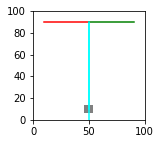

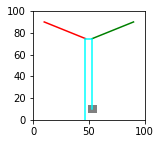

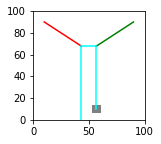

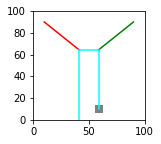

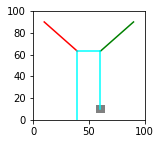

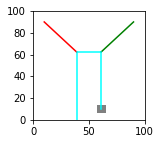

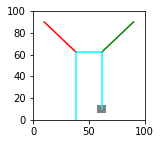

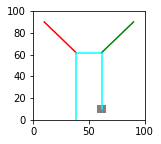

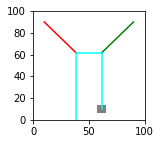

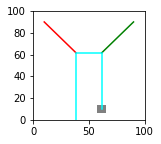

In [54]:

# Runner color
colors = ['red',
          'green']

# Runner anchor positions
anchors = [(10, 90),
           (90, 90)]

# Length of runners
lens = [40,
        40]

# Starting angles (could all be 0)
angles = [0,
          180]


iterations = 10


colors = np.array(colors)
anchors = np.array(anchors)
lens = np.array(lens)
angles = np.array(angles)


for i in range(iterations):    

    # Draw scene and get rope bisection angles
    bisections = render_scene(anchors, lens, angles, colors, True)

    # Move each runner halfway to the bisection angle
    next_angles = []
    for i in range(len(angles)):
        next_angles.append(bisecting_angle(angles[i], bisections[i]))
    angles = next_angles
    
    # If any two runners are crossed, move them to their fully-extended point
    uncross_adjacent_runners(anchors, lens, angles)

    plt.show()


